# Network Metrics
Includes analysis and visualizations based on degree distributions. Most bipartite networks analyzed in the literature are not directed. That means that each node has a single degree, which is simply the number of links that node has. -

Our $pq$-network is directed. This means that each node had two degrees: in-degree (the number of links going into the node) and out-degree (the number of links going out of the node). So we have four degree distributions: distribution of in-degrees of $p$-nodes, distribution of out-degrees of $p$-nodes; distribution of in-degrees of $q$-nodes; and distribution
of out-degrees of $q$-nodes. The last distribution is trivial since all q-nodes have out-degree equal to 1 (each question is asked by a single person). Thus, we can characterize each $pq$-network by three degree distributions.

In [4]:
import xlrd 
import matplotlib.pyplot as plt
import matplotlib.colorbar
import matplotlib.colors
import matplotlib.cm
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import chisquare
from math import factorial
from math import exp
from scipy.stats.distributions import chi2
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter

import os 

from pq_helper import get_dataframe

We will define the following helper functions:

In [2]:
def chi_squared_test(observed, mu, total):
    expected = []
    sum = 0
    for value in range(len(observed) - 1): 
        expected.append(total * (exp(-mu) * mu**value / factorial(value)))
        sum += total * (exp(-mu) * mu**value / factorial(value))
    expected.append(total - sum)
    (testStatistic, pValue) = chisquare(observed, f_exp=expected, 
                                        ddof=len(observed) - 1)  
    # note: the p-value returned by the chisquare function seems to be 
    # incorrect for the test statistic; I verified the return value of chi2.sf 
    # with both online tables of chi-squared value as well as Mathematica and 
    # MATLAB
    p = chi2.sf(testStatistic, len(observed) - 1)
    return (testStatistic, p)

def color_by_nscore(Outdegree, Indegree, NScore):
    df = pd.DataFrame(dict(Outdegree=Outdegree, Indegree=Indegree, 
                           NScore=NScore))     
    cmap = plt.cm.get_cmap('RdYlBu') 
    
    # Normalize to the range of possible values from NScore
    norm = matplotlib.colors.Normalize(vmin=NScore.min(), vmax=NScore.max())
    
    # create a color dictionary  
    colors = {}
    for cval in NScore:
        colors.update({cval : cmap(norm(cval))})
    
    fig = plt.figure(figsize=(20,5))
    #fig = plt.figure(figsize=(200,5)) # use for zoomed view of outdegree 0
    #fig = plt.figure(figsize=(50,5)) # use for zoomed view of outdegree 1        
    m = sns.swarmplot(Outdegree, Indegree, hue=NScore, palette = colors)
    plt.gca().legend_.remove()
    plt.title('In-Degree vs Out-Degree of P-Nodes') 
    
    divider = make_axes_locatable(plt.gca())
    ax_cb = divider.new_horizontal(size="5%", pad=0.05)
    fig.add_axes(ax_cb)
    clb = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap, norm=norm)
    clb.set_label('N-Score')
    plt.show()     
    
def avg_degree(sheet, total):
    Outdegree = sheet['Out-Degree']
    Indegree = sheet['In-Degree']  
    total_out = 0
    total_in = 0
    counter = 0
    
    for i in range(total):
        if sheet['Status'][i] == 1:
            total_out += Outdegree[i]
            counter += 1
        
    for i in range(total):
        if sheet['Status'][i] == 1:
            total_in += Indegree[i]
            
    # average outdegree of status 1 p-nodes
    avg_out = total_out / counter
    
    # average indegree of status 1 p-nodes
    avg_in = total_in / counter 
    
    return (avg_in, avg_out)

First, load in the data:

In [73]:
data_path = 'data/'
path = os.path.join(data_path, 'acm95a100a2018_anonymized_modified.xlsx')
(p_nodes, q_nodes, links, mod_p_nodes) = get_dataframe(path)

In [59]:
p_nodes

,ID,Role,Class,Option,Section,DaysOnline,Views,Contributions,Questions,Notes,Answers,N-Score,Grade,Status,In-Degree,Out-Degree,Seniority
0,P1,Student,U2,ME,5.0,48,60,0,0,0,0,0.531170,B+,0,0,0,U
1,P2,Student,U2,ACM,5.0,150,219,14,0,0,13,0.918357,A+,1,1,5,U
2,P3,Student,U2,ACM,7.0,245,215,9,1,0,4,0.864791,A+,1,4,4,U
3,P4,Student,U3,CS,1.0,107,215,3,0,0,2,0.928847,A+,1,0,3,U
4,P5,Student,U2,ME,3.0,53,216,38,10,0,15,0.944688,A+,1,20,9,U
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,P192,TA,NaN,NaN,8.0,59,88,1,0,0,0,NaN,NaN,1,0,1,N
192,P193,TA,NaN,NaN,9.0,78,34,0,0,0,0,NaN,NaN,1,0,1,N
193,P194,TA,NaN,NaN,10.0,36,53,3,0,2,1,NaN,NaN,0,0,0,N
194,P195,Head TA,NaN,NaN,NaN,74,237,228,0,7,153,NaN,NaN,1,0,125,N


Observe that we have computed In-Degree and Out-Degree for all $p$-nodes and In-Degree for all $q$-nodes and added these node attributes to `acm95a100a2018_anonymized_modified.xlsx`. We reproduce the code for generating the degrees below:

```{python}
# p-node Out-Degree
p_nodes['Out-Degree'] = [0]*len(p_nodes)

out = links["Start"].value_counts()
nodes = links["Start"].value_counts().index

for node in nodes:
    if node[0] == 'P':
        row_index = int(node[1:]) - 1
        p_nodes.loc[row_index, 'Out-Degree'] = out.loc[node]
     
# p-node and q-node In-Degree
p_nodes['In-Degree'] = [0]*len(p_nodes)
q_nodes['In-Degree'] = [0]*len(q_nodes)

ins = links["End"].value_counts()
nodes = links["End"].value_counts().index
for node in nodes:
    row_index = int(node[1:]) - 1
    if node[0] == 'P':
        p_nodes.loc[row_index, 'In-Degree'] = ins.loc[node]
    else:
        q_nodes.loc[row_index, 'In-Degree'] = ins.loc[node]
```

We extract all unique values of In-Degree and Out-Degree for $p$-nodes in ascending order for later use. Most of our analysis will be done on students only, as instructor and TAs are expected to participate heavily in the network, unlike students.

In [58]:
# list of p-nodes out-degrees (students only)
p_node_out = np.sort(mod_p_nodes['Out-Degree'].value_counts().index)
    
# list of p-nodes in-degrees (students only; note that instructors should 
# all have in-degrees of zero, since they don't ask questions)
p_node_in = np.sort(mod_p_nodes['In-Degree'].value_counts().index) 

For our first visualization, we plot the average In-Degree of $p$-nodes against Out-Degree, coloring by average `NScore`:

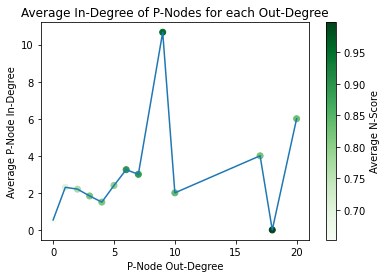

In [87]:
avg_p_in = [] # holds average in-degree of p-nodes with each out-degree 
avg_n_score = [] # holds average n-score of p-nodes with each out-degree
for x in p_node_out: 
    total_in = 0
    total_n = 0
    number = 0 
    for i in range(184):
        if mod_p_nodes['Out-Degree'][i] == x:
            total_in += mod_p_nodes['In-Degree'][i]
            number += 1
            total_n += mod_p_nodes['N-Score'][i]
    avg_p_in.append(total_in / number)  
    avg_n_score.append(total_n / number)
        
plt.scatter(p_node_out, avg_p_in, c=avg_n_score, cmap='Greens')
c = plt.colorbar()
c.set_label('Average N-Score')
plt.plot(p_node_out, avg_p_in)
plt.xlabel('P-Node Out-Degree')
plt.ylabel('Average P-Node In-Degree')
plt.title('Average In-Degree of P-Nodes for each Out-Degree') 
plt.show()

We do the same for average Out-Degree against In-Degree:

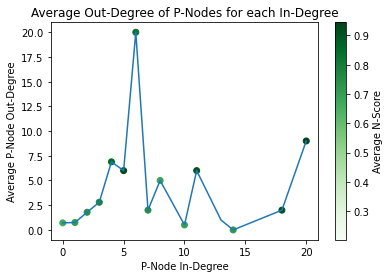

In [88]:
avg_p_out = [] # holds average out-degree of p-nodes with each in-degree 
avg_n_score2 = [] # holds average n-score of p-nodes with each in-degree
for x in p_node_in: 
    total_out = 0
    total_n2 = 0
    number2 = 0 
    for i in range(184):
        if mod_p_nodes['In-Degree'][i] == x:
            total_out += mod_p_nodes['Out-Degree'][i]
            number2 += 1
            total_n2 += mod_p_nodes['N-Score'][i]
    avg_p_out.append(total_out / number2)  
    avg_n_score2.append(total_n2 / number2)
        
plt.scatter(p_node_in, avg_p_out, c=avg_n_score2, cmap='Greens')
c = plt.colorbar()
c.set_label('Average N-Score')
plt.plot(p_node_in, avg_p_out)
plt.xlabel('P-Node In-Degree')
plt.ylabel('Average P-Node Out-Degree')
plt.title('Average Out-Degree of P-Nodes for each In-Degree') 
plt.show()

There is no obvious trend between Out-Degree and In-Degree. Looking at the average `NScore`s, it appears that those $p$-nodes with the highest in-degree (asked a lot of questions) did tend to have relatively high `NScore`s.

Next, we wish to visualize the degree distributions for each type of node. We work with Status $=1$ $p$-nodes only, as those who did not participate in the network have In- and Out-Degrees of 0. We begin with the In-Degrees of $p$-nodes:

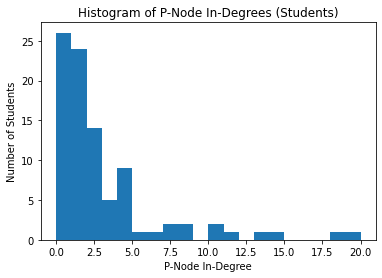

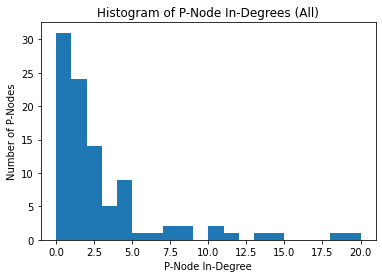

In [102]:
# list of in-degrees of status=1 p-nodes (students only) 
status1_in = mod_p_nodes[:184].loc[mod_p_nodes[:184]['Status'] == 1]['In-Degree']
    
plt.hist(status1_in, bins=20, range=(0, 20))
plt.xlabel('P-Node In-Degree')
plt.ylabel('Number of Students')
plt.title('Histogram of P-Node In-Degrees (Students)')
plt.show()
    
# list of in-degrees of status=1 p-nodes (including TAs and instructor) 
status1_in_all = p_nodes.loc[p_nodes['Status'] == 1]['In-Degree']  

plt.hist(status1_in_all, bins=20, range=(0, 20))
plt.xlabel('P-Node In-Degree')
plt.ylabel('Number of P-Nodes')
plt.title('Histogram of P-Node In-Degrees (All)')
plt.show()

The distribution of $p$-node In-Degrees is skewed to the right, with most participants in the network asking 5 or fewer questions. With the addition of instructors and TAs, who may have made some administrative posts, the number of $p$-nodes with In-Degree 1 increases slightly. Otherwise, the two plots are identical.

Next, we examine the Out-Degrees of $p$-nodes:

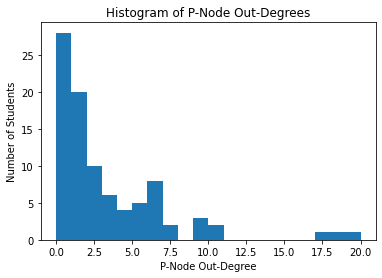

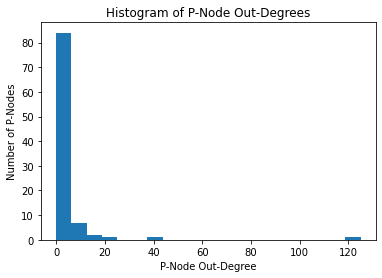

In [105]:
# list of out-degrees of status=1 p-nodes (students only) 
status1_out = mod_p_nodes[:184].loc[mod_p_nodes[:184]['Status'] == 1]['Out-Degree']

plt.hist(status1_out, bins=20, range=(0, 20))
plt.xlabel('P-Node Out-Degree')
plt.ylabel('Number of Students')
plt.title('Histogram of P-Node Out-Degrees')  
plt.show()

# list of out-degrees of status=1 p-nodes (including TAs and instructor) 
status1_out_all = p_nodes.loc[p_nodes['Status'] == 1]['Out-Degree']

plt.hist(status1_out_all, bins=20, range=(0, 125))
plt.xlabel('P-Node Out-Degree')
plt.ylabel('Number of P-Nodes')
plt.title('Histogram of P-Node Out-Degrees')
plt.show()

We again observe distributions skewed to the right, with most participants answering less than 8 questions. A few large outliers exist among students who answered nearly 20 questions. With the addition of instructor and TAs, we see many more large outliers, as expected, since instructor and TAs answered most of the questions posed. 

Finally, we look at $q$-node In-Degrees:

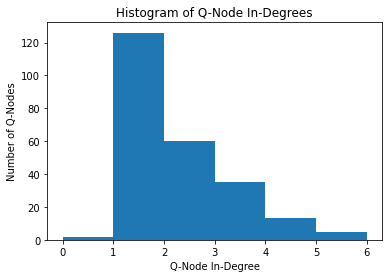

In [106]:
plt.hist(q_nodes['In-Degree'], bins=6, range=(0, 6))
plt.xlabel('Q-Node In-Degree')
plt.ylabel('Number of Q-Nodes')
plt.title('Histogram of Q-Node In-Degrees')
plt.show()

The distribution is somewhat skewed to the right, with most questions answered by 1-3 people. Only two questions were not answered, as instructor and TAs ensured that most questions were answered. 

We next use the $\chi^2$ goodness of fit test to test whether the degree distributions are Poisson.

In [18]:
ordered_nodes = []
ordered_edges = []
duplicate_nodes = {} # store number of times a p-node has participated
    
# iterate through all links
for i in range(len(links['ID'])):
    start = links['Start'][i]
    end = links['End'][i]
        
    if start[0] == 'P': # [P answers Q]; always add new p-node but never new q-node
            
        # if p-node has not participated before
        if start not in duplicate_nodes:
            duplicate_nodes[start] = 0
            
        # add new p-node
        count = duplicate_nodes[start]
        duplicate_nodes[start] += 1
        start += '_' + str(count+1) # update start of link
        ordered_nodes.append(start)           
            
    else: # [Q asked by P]; always add new q-node and new p-node 
            
        # add new q-node
        ordered_nodes.append(start)
            
        # if p-node has not participated before
        if end not in duplicate_nodes:
            duplicate_nodes[end] = 0
        
        # add new p-node
        count = duplicate_nodes[end]
        duplicate_nodes[end] += 1            
        end += '_' + str(count+1) # specify end of link
        ordered_nodes.append(end)           
         
    # add edge corresponding to link 
    ordered_edges.append((start, end))   
    
q = 1
p = 2
times = [0] * 910
data = [0] * 910
    
time = 1
for i in range(len(ordered_nodes)):
    if ordered_nodes[i][0] == 'Q': # question is asked
        data[i] = q    # add q-node 
    else: 
        data[i] = p
        # check if p-node follows a q-node (person asks question)
        if ordered_nodes[i-1][0] == 'Q':
            time -= 1 # add p-node at same time as previous q-node
                
    times[i] = time # add node at current timestep
    time += 1

Let's examine the temporal plot:

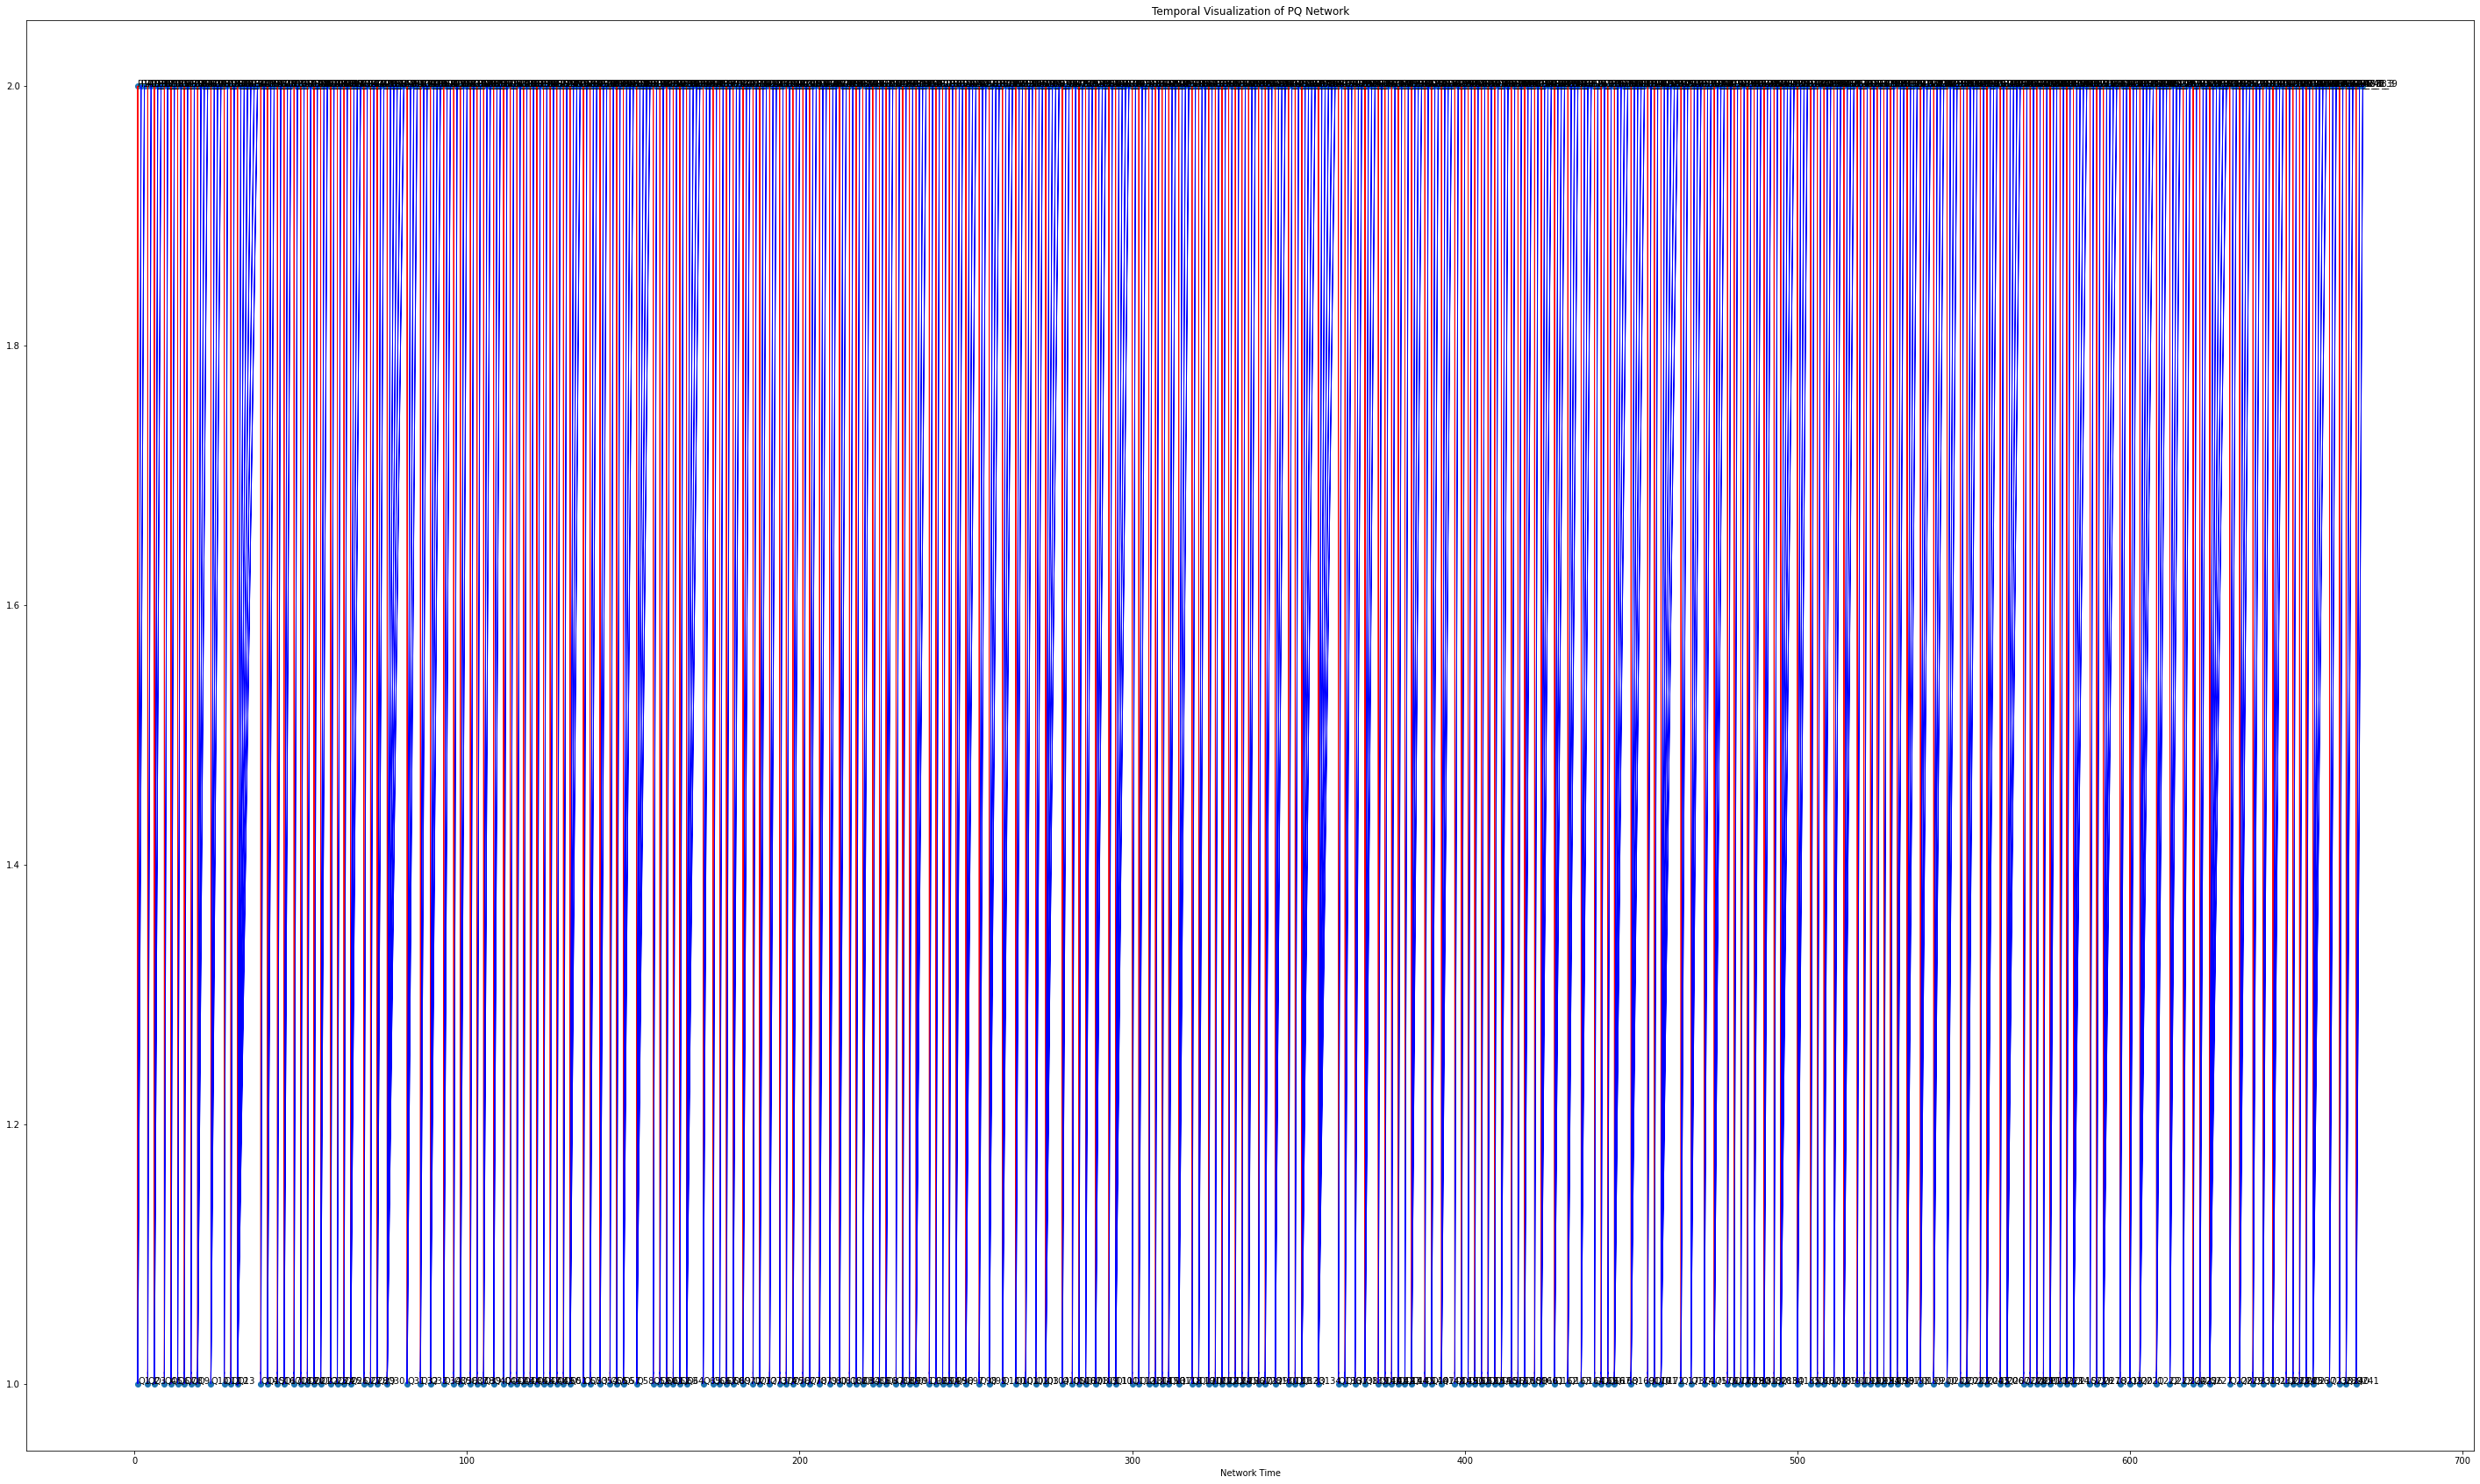

In [22]:
# plot and label nodes
fig, ax = plt.subplots(figsize=(50,30))
ax.scatter(times, data)
for i, txt in enumerate(ordered_nodes):
    ax.annotate(txt, (times[i], data[i]))
    
# plot links
for edge in ordered_edges:
    from_node = edge[0]
    to_node = edge[1]
        
    f = ordered_nodes.index(from_node)
    t = ordered_nodes.index(to_node)
        
    # edges from q-node to p-node are red, from p-node to q-node are blue
    if from_node[0] == 'Q':
        color = 'red'
    else:
        color = 'blue'        
        
    plt.arrow(times[f], data[f], times[t] - times[f], data[t] - data[f], 
                length_includes_head=True, color=color, head_width=0.006, head_length=0.01)
    plt.title('Temporal Visualization of PQ Network')
    plt.xlabel('Network Time')

Zoomed-in versions of the plot above can be found under `/figures/network_visualizations/`.

Based on the temporal visualization and an examination of the data, it appears that the links in our dataset do not encode relative network times between answers. For example, it is reasonable to assume that in real-time, scenarios of the following type occurred: suppose that $q_1$ was asked, then $q_2$ was asked. Next, $q_2$ was answered before $q_1$ was answered. Based on our data, the link representing the answer to $q_1$ appears before the link representing the answer to $q_2$ in network time because $q_1$ appeared first. This leads to formations of the kind pictured above, where p-nodes that answer questions must be answering the most recently asked question and none of the links cross. While this leads to a clean visualization, it also results in the loss of information regarding the actual order in which questions were answered.

### Attributions

Notebook created by Amanda Li. 

Modified from `network_metrics_degree_distributions.py` by Amanda Li.